In [1]:
import sys
import numpy as np
sys.path.append("../")
import matplotlib.pyplot as plt
import torch
from irradiance.models.kan_success import KANDEMSpectrum
%cd ..

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


/home/andres_munoz_j/2024-HL-SPI3S-MEGS-AI


In [2]:
aia_stack = np.load('/mnt/disks/data-extended/preprocessed/AIA_256/AIA_2014-03-11T00:00:03.npy')
# checkpoint_path = '/home/christophschirninger/dem_runs/debug_dem.ckpt-v2.ckpt'
checkpoint_path = '/home/andres_munoz_j/megsai_runs/dem_sp_128_64.ckpt'
eve_norm_path = '/mnt/disks/data-extended/preprocessed/EVE/EVS_MEGS-A_stats.npy'
uv_norm = '/mnt/disks/data-extended/preprocessed/AIA_256_EVS_MEGS-AB_stats.npz'

eve_norm = np.load(eve_norm_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
model_ckpt = torch.load(checkpoint_path)

/var/tmp/ipykernel_7132/1604141597.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ckpt = torch.load(checkpoint_path)


In [4]:
#model = KANDEMSpectrum.load_from_checkpoint(checkpoint_path)

In [4]:
aia_stack.shape

(9, 256, 256)

In [5]:
with torch.no_grad():

    x = torch.tensor(aia_stack)[None, 0:7, :, :].to(device)
    x = x.unfold(2, 3, 1).unfold(3, 3, 1) # batch, channel, pixel_x, pixel_y, kanfov, kanfov
    x = x.reshape(x.shape[0], x.shape[1], -1, 3, 3) # batch, channel, pixel_x*pixel_y, kanfov, kanfov
    x = x.transpose(1, 2) # batch, pixel_x*pixel_y, channel, kanfov, kanfov
    x = x.reshape(x.shape[0], x.shape[1], -1) # batch, pixelx_*pixel_y, channel*kanfov*kanfov
    x = x[:, :, None, :].expand((x.shape[0], x.shape[1], model_ckpt['model'].t_query_points.shape[0], x.shape[2])) # batch, pixel_x*pixel_y, t_query_points, channel*kanfov*kanfov
    # Normalize input
    x = x/model_ckpt['model'].uv_norm

    # Concatenate log10(T) subtracting base exponent
    x = torch.cat((x, (model_ckpt['model'].t_query_points - torch.tensor(model_ckpt['model'].base_temp_exponent).to(device))[None, None, :, None].expand(x.shape[0], x.shape[1], x.shape[2], 1)), dim=3)

    dem = model_ckpt['model'].forward(x.cpu()).squeeze()

In [6]:
dem.shape

torch.Size([64516, 20])

In [7]:
em = torch.trapezoid(dem, x=torch.pow(10, model_ckpt['model'].t_query_points.to('cpu')), dim=1) # batch, channel

In [19]:
np.sqrt(em.shape[0])

254.0

In [8]:
em = em.reshape((int(np.sqrt(em.shape[0])), int(np.sqrt(em.shape[0]))))

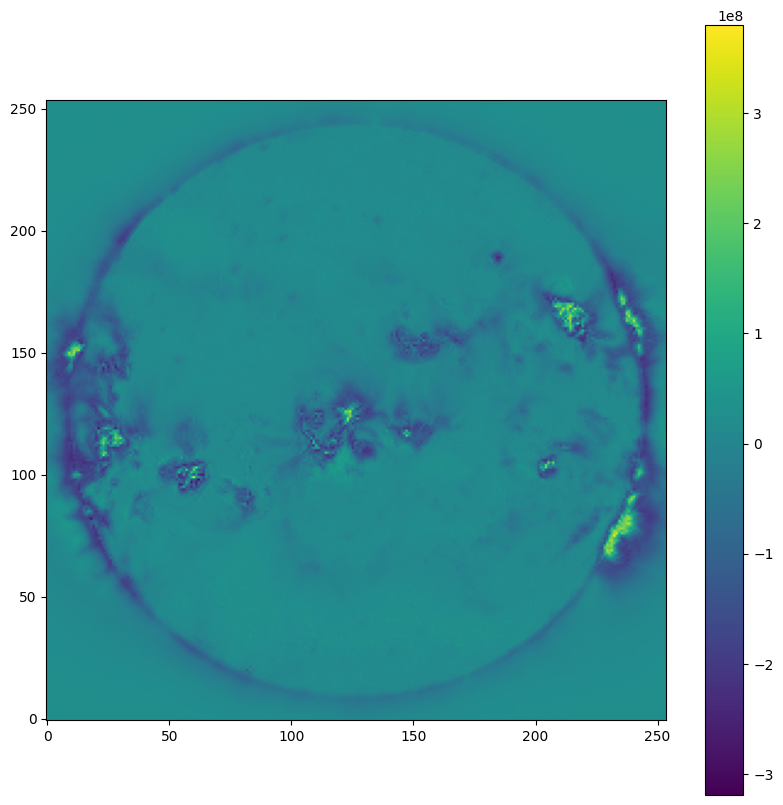

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(em.cpu().numpy(), origin='lower')
plt.colorbar()
plt.show()